## Author: Muhammad

In [1]:
import numpy as np
import pandas as pd
from pycaret.regression import *
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from catboost import CatBoostRegressor
import shap

In [3]:
# Reading the cleaned dataset
joined = pd.read_csv("../data/ACS/acs_cleaned_data.csv")

In [4]:
# Number of unique redlining index values
len(np.unique(joined.reweighted_redline_index.values.round(2)))

322

In [6]:
exp1 = setup(joined, target = "reweighted_redline_index", silent=True, verbose=False)

In [19]:
# MAE = Mean Absolute Error
# MSE = Mean Squared Error
# RMSE = Root Mean Squared Error
# R2 = R-Squared
# RMLSE = Root Mean Squared Logarithmic Error
# MAPE = Mean Absolute Percentage Error
# TT = Time Taken For Computation
best_model = compare_models(verbose=False)

In [20]:
print(type(best_model))

<class 'catboost.core.CatBoostRegressor'>


### CatBoost — Beeswarm Plot

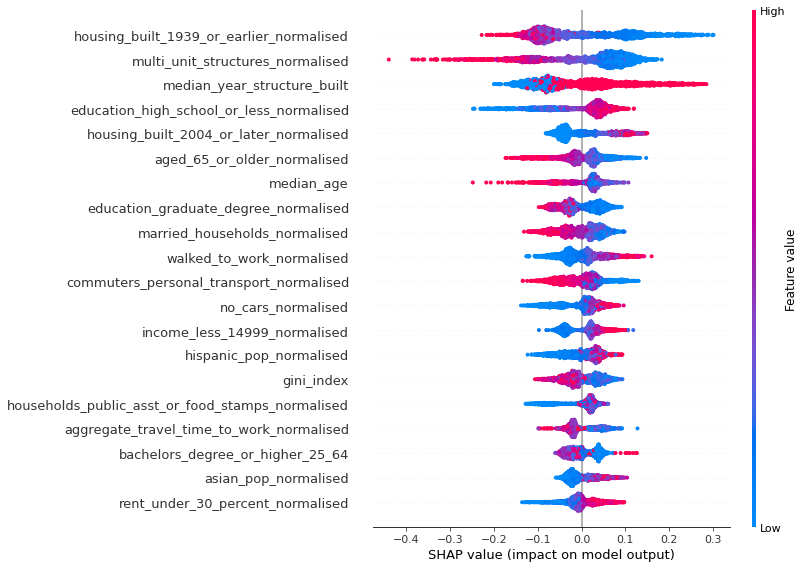

In [26]:
interpret_model(best_model)

### CatBoost — Mean Absolute Values

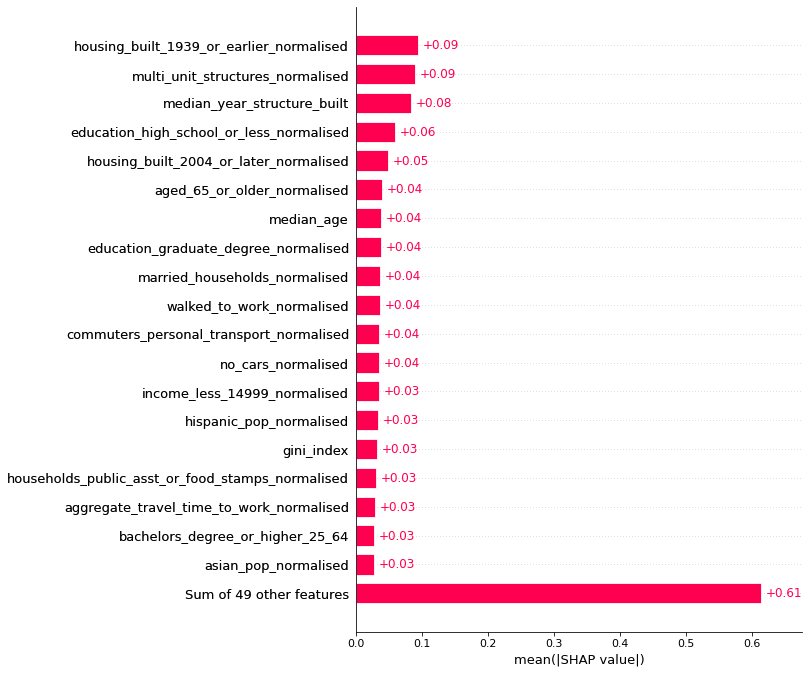

In [39]:
X = get_config("X_test")
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)
shap_obj_best_model = explainer(X)

# Saving the Shapley values to file
pd.DataFrame(shap_obj_best_model.values, columns=X.columns).to_csv("output/shap_values_cat.csv")

# Plotting the mean absolute values
shap.plots.bar(shap_obj_best_model.abs.mean(0), max_display=20)

### \*Tuned\* CatBoost — Beeswarm Plot

In [28]:
tuned_model = tune_model(best_model, verbose=False)

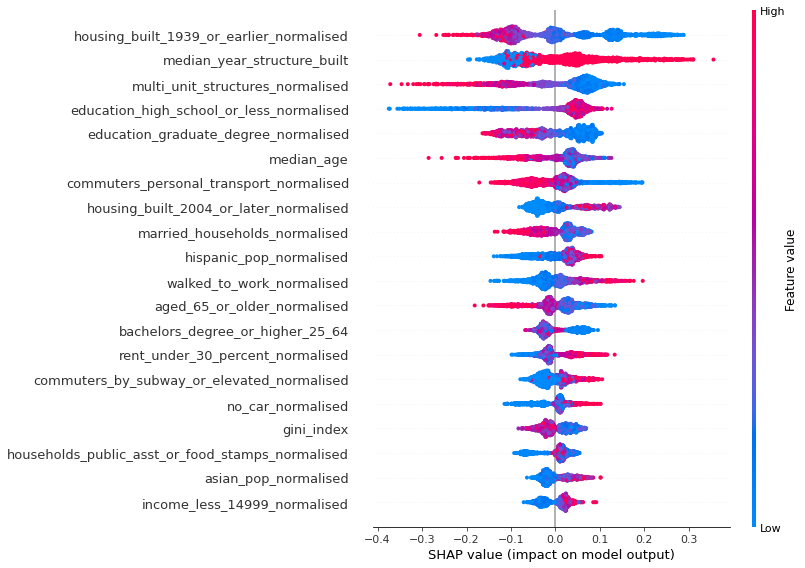

In [31]:
interpret_model(tuned_model)

In [ ]:
### \*Tuned\* CatBoost — Mean Absolute Values

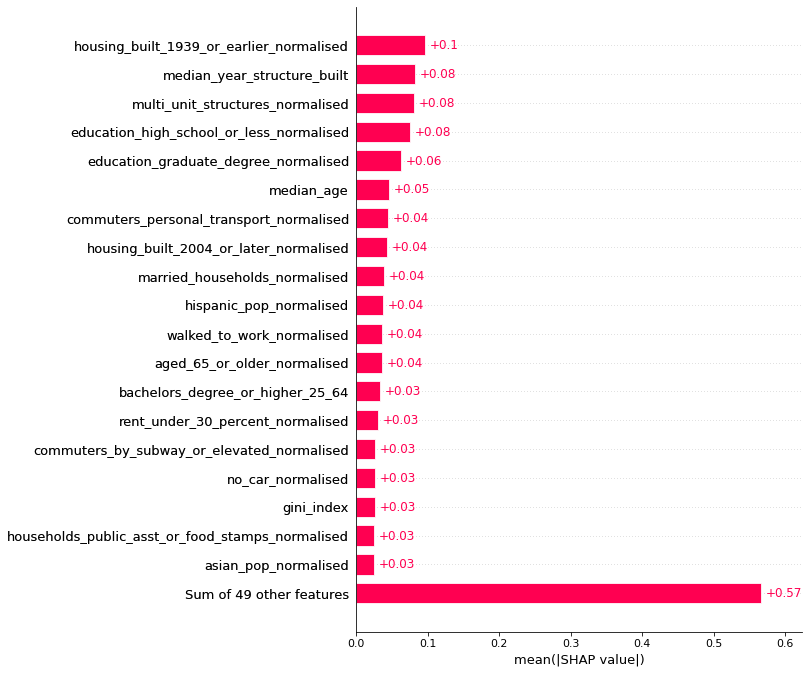

In [40]:
X = get_config("X_test")
explainer = shap.TreeExplainer(tuned_model)
shap_values = explainer.shap_values(X)
shap_obj_tuned_model = explainer(X)

# Saving the Shapley values to file
pd.DataFrame(shap_obj_tuned_model.values, columns=X.columns).to_csv("output/shap_values_tuned_cat.csv")

# Plotting the mean absolute values
shap.plots.bar(shap_obj_tuned_model.abs.mean(0), max_display=20)

### CatBoost — Beeswarm

![](output/shap_beeswarm_cat.png)

### CatBoost — Mean Asbolute Values

![](output/shap_mean_cat.png)

### \*\*Tuned\*\* CatBoost — Beeswarm Plot

![](output/shap_beeswarm_tuned_cat.png)

### \*\*Tuned\*\* CatBoost — Mean Absolute Values

![](output/shap_mean_tuned_cat.png)

# Interpreting Shapley Values

Please see these [four short videos](https://www.coursera.org/lecture/ai-for-medical-treatment/individual-feature-importance-TnfPK) for a better understanding of Shapley values. You will, unfortunately, need to create a Coursera account, because they only let you watch three videos without an account.

In summary, though, each point in the above graph represents a single sample.This is what sets Shapley values apart from 'global' feature importance methods, because it shows you the importance of each feature on a per-sample basis.

The colour of the point shows the value of the feature for that sample. So, for the `median_age` column, a red value means the census tract had a higher median age, while a blue point indicates that the tract had a lower median age.

The x-axis, meanwhile, shows the contribution of that particular feature on the prediction for that particular sample. A positive value on the x-axis indicates a positive contribution toward the predicted value (i.e., an increase in the predicted value) compared to the mean of the overall population, while a negative value on the x-axis indicates a decrease in the predicted value compared to the mean of the overall population. 

This is the *other useful thing* about Shapley values, because **they not only indicate how important a particular feature is, but also what effect a higher/lower feature value has on the prediction** (i.e., does it increase/decrease the predicted value).

Putting it all together, if we consider the `median_age`, what the above graph, with red points being clustered around the left and the blue points clustered around the right, shows is that when a census tract has a higher median age (i.e., red points), this is likely to make the redlining index value of the census tract to decrease.

Note that the way Akash set it up, an index value of 1.0 corresponds to the highest grade (A), while a value of 5.0 corresponds to the lowest grade (E).

As such, the fact that a higher `median_age` corresponds to a lower index value means that **the higher the median age of the census tract, the more likely that it has a good grade (e.g., an A)**, and vice versa.

This could be explained by, perhaps, considering the fact that older people are more likely to be better off economically, and therefore more likely to live in a good neighbourhood, which would result in a better redlining grade. Alternatively, it is sometimes the case that people with lower incomes have more children on average (not sure if this is the case in the U.S., but it is sometimes the case in less developed countries). As such, lower income neighbourhood = more children per capita = lower median age.

These are, of course, just some guesses on my part. The true reason for the correlation would require further research.

In [ ]:
top_5 = [
    'housing_built_1939_or_earlier_normalised',
    'multi_unit_structures_normalised',
    'median_year_structure_built',
    'aged_65_or_older_normalised',
    'education_high_school_or_less_normalised'
]

X = joined.copy()

# Dropping for now because they have many null values.
## !!!! Will need to check the cause later on
X.drop(columns=['aggregate_travel_time_to_work_normalised', 'pop_now_married_normalised'], inplace=True)
print(X.shape)
X.dropna(axis=0, how="any", inplace=True)
y = X.pop('reweighted_redline_index')
X = X[top_5]
print(X.shape)
X.head()

In [ ]:
model = LinearRegression()
model.fit(X, y)
# R^2 of predictions on training data
model.score(X, y)

In [ ]:
list( zip( top_5, np.round(model.coef_, 3) ) )

In [ ]:
# Coefficients of each of the variables
fig = plt.figure(figsize=(10, 4))
plt.bar([x[:15] for x in top_5], np.round(model.coef_, 3))
plt.savefig("output/regression_coefficients.png")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c9a4f701-31a5-4164-b3f3-c09cddf1309e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>